In [14]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dropout
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
import scipy
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import util
import re

Cargo datasets

In [15]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Armo features

In [16]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [57]:
def clean_tweet(text):
    text = re.sub('@.*?(\s*)', str(), text)
    text = re.sub('http(s?):\/\/.*\s*', str(), text)
    text = re.sub('\?*', str(), text)
    text = re.sub('OffensiveåÊContent', 'offensive content', text)
    text = re.sub('\n', str(), text)
    text = re.sub('#(.*?)(\s|$)', ' ', text)
    text = re.sub('\bdis\b', ' this ', text)
    text = re.sub('\bda\b', ' the ', text)
    return text.lower()

In [58]:
x = [clean_tweet(tweet) for tweet in train_df['text'].values]
y = train_df['target'].values

train, test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1000)

Cargo los embeddings

In [59]:
embedding_dim = 300 
max_text_length = 100
news_path = './data/embeddings/word2vec.bin'
if not embeddings_index:
    embeddings_index = KeyedVectors.load_word2vec_format(news_path, binary=True)

Tokenizo los tweets y armo la matriz de embeddings

In [60]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)

X_train = tokenizer.texts_to_sequences(train)
X_test = tokenizer.texts_to_sequences(test)

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=max_text_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_text_length)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
i = 0
count = 0
for word in tokenizer.word_index:
    if word in embeddings_index:
        count += 1
        embedding_matrix[i] = embeddings_index[word]
    i += 1
print(f"Words in embeddings: {count}/{vocab_size-1}  {(count)/(vocab_size-1)}")    

Words in embeddings: 9635/14429  0.6677524429967426


In [61]:
print(tokenizer.word_index)

{'the': 1, 'a': 2, 'in': 3, 'to': 4, 'of': 5, 'i': 6, 'and': 7, 'is': 8, 'for': 9, 'on': 10, 'you': 11, 'my': 12, 'with': 13, 'it': 14, 'that': 15, 'by': 16, 'at': 17, 'this': 18, 'from': 19, 'are': 20, 'be': 21, 'have': 22, 'was': 23, 'as': 24, 'like': 25, 'me': 26, 'but': 27, 'up': 28, 'just': 29, 'amp': 30, 'so': 31, 'not': 32, 'your': 33, 'out': 34, 'all': 35, 'when': 36, 'will': 37, 'fire': 38, 'after': 39, 'has': 40, "i'm": 41, 'no': 42, 'get': 43, 'an': 44, 'we': 45, 'if': 46, 'now': 47, 'about': 48, 'new': 49, 'one': 50, 'more': 51, 'what': 52, '2': 53, 'people': 54, 'or': 55, 'they': 56, 'been': 57, 'he': 58, "don't": 59, "it's": 60, 'into': 61, 'who': 62, 'how': 63, 'do': 64, 'over': 65, 'emergency': 66, 'there': 67, 'video': 68, 'can': 69, 'police': 70, 'than': 71, 'some': 72, '3': 73, 'her': 74, 'disaster': 75, 'his': 76, 'still': 77, 'u': 78, 'body': 79, 'were': 80, "'": 81, 'would': 82, 'burning': 83, 'back': 84, 'got': 85, 'news': 86, 'storm': 87, 'suicide': 88, 'buildin

Creo el modelo y corro la CNN

In [74]:
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_text_length, weights=[embedding_matrix], trainable=False))
    model.add(Conv1D(128, 5, activation='relu'))
    #model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Epoch 1/15
191/191 [==============================] - 5s 26ms/step - loss: 0.6308 - accuracy: 0.6479 - val_loss: 0.5629 - val_accuracy: 0.7223
Epoch 2/15
191/191 [==============================] - 5s 25ms/step - loss: 0.4639 - accuracy: 0.7918 - val_loss: 0.5550 - val_accuracy: 0.7446
Epoch 3/15
191/191 [==============================] - 5s 25ms/step - loss: 0.3027 - accuracy: 0.8882 - val_loss: 0.5610 - val_accuracy: 0.7262
Epoch 4/15
191/191 [==============================] - 5s 26ms/step - loss: 0.1892 - accuracy: 0.9414 - val_loss: 0.6276 - val_accuracy: 0.7321
Epoch 5/15
191/191 [==============================] - 5s 27ms/step - loss: 0.1409 - accuracy: 0.9589 - val_loss: 0.6689 - val_accuracy: 0.7380
Epoch 6/15
191/191 [==============================] - 5s 26ms/step - loss: 0.1124 - accuracy: 0.9668 - val_loss: 0.6801 - val_accuracy: 0.7262
Epoch 7/15
191/191 [==============================] - 5s 27ms/step - loss: 0.0855 - accuracy: 0.9695 - val_loss: 0.8740 - val_accuracy: 0.7393

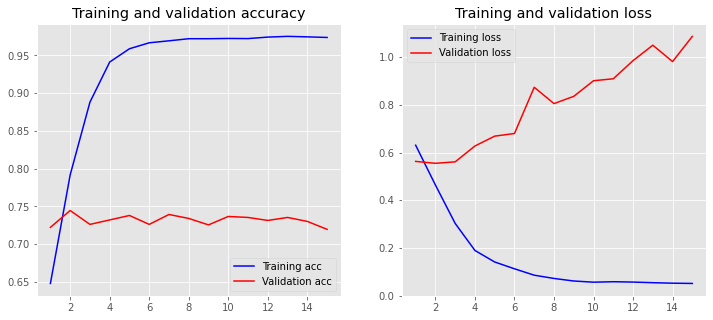

In [75]:
model = create_model()
history = model.fit(X_train, y_train, epochs=15, shuffle=True, validation_data=(X_test, y_test))
plot_history(history)

Vemos cuales fallo

In [52]:
prediction = model.predict_classes(X_test)
df = pd.DataFrame({'text': test, 'target': y_test, 'prediction': [x[0] for x in prediction]})

In [53]:
pd.set_option('display.max_rows', len(df))
pd.set_option('display.max_colwidth', None)
df[df['target'] != df['prediction']]

,text,target,prediction
1,da judge gave dis girl 5pm curfew,0,1
2,us wont upgrade its infrastructure,1,0
4,nigeltanner1 believe it or not we've had too much rain here. our newly planted maple trees are actually drowning.,1,0
9,in response to trauma children of addicts develop a defensive self - one that decreases vulnerability. (3,0,1
13,dad bought a dvd that looks like a science doc on the front but i read the back and it's actually about the impending biblical apocalypse,1,0
15,reddit will now quarantine offensive content,1,0
22,sapphirescallop destroy oppa image oops! there's nothing left right haaaaaa,0,1
23,they should name hurricanes with black people names. i'd be terrified of hurricane shanaynay!,0,1
30,massacre at {1} : has the world forgotten the {1} {1} {1} {1},1,0
31,so when you're caught in a landslidei'll be there for youand in the rain give you sunshinei'll be there for you,0,1


In [54]:
df[df['target'] == df['prediction']]

,text,target,prediction
0,11-year-old boy charged with manslaughter of toddler: report: an 11-year-old boy has been charged with manslaughter over the fatal sh...,1,1
3,dyannbridges yeshayad check out this {1} preview of claytonbryant danger zone coming soon!,0,0
5,no {1} of {1} in {1} {1} {1} {1} {1} {1} {1} {1} {1} {1},1,1
6,potential storm surge flooding map by national hurricane center,1,1
7,olrules welcome - read a free chapter of my new book encounters with jesus. it's full of hope.,0,0
8,on 1st august {1} jets bombed the village zergele in qendil and killed 8 civilians and 15 others wounded,1,1
10,mi_country_hick pfft! i wish i had a bot like that. instead i'm daily inundated with 140 characters of the same unhinged machismo bullshit.,0,0
11,i'm gonna fight taylor as soon as i get there.,0,0
12,deldryden if i press on the twitch will my head explode,0,0
14,i tried making a chocolate and peanut butter lava cake using my {1} protein shake mix and aû_,0,0


In [26]:
Calculemos el test para kaggle

SyntaxError: invalid syntax (<ipython-input-26-e3510059fc31>, line 1)

In [193]:
ids = test_df['id']

final_test = process_dataset(test_df['text'].values)

prediction = model.predict_classes(final_test)
final_df = pd.DataFrame({'target': [x[0] for x in prediction]}, index=ids)
final_df

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [194]:
final_df['target'].value_counts()

1    2038
0    1225
Name: target, dtype: int64

In [195]:
final_df.count()

target    3263
dtype: int64

In [144]:
final_df.to_csv('nn.csv')